# Introduction to Cloud Masks

Note that this  lesson is just an overview of cloud masking. We are not using the data
that you will use in your homework for this week. 


## About Landsat Scenes

Landsat satellites orbit the earth continuously collecting images of the Earth's
surface. These images, are divided into smaller regions - known as scenes.

> Landsat images are usually divided into scenes for easy downloading. Each
> Landsat scene is about 115 miles long and 115 miles wide (or 100 nautical
> miles long and 100 nautical miles wide, or 185 kilometers long and 185 kilometers wide). -*wikipedia*


### Challenges Working with Landsat Remote Sensing Data

In the previous lessons, you learned how to import a set of geotiffs that made
up the bands of a Landsat raster. Each geotiff file was a part of a Landsat scene,
that had been downloaded for this class by your instructor. The scene was further
cropped to reduce the file size for the class.

You ran into some challenges when you began to work with the data. The biggest
problem was a large cloud and associated shadow that covered your study
area of interest - the Cold Springs fire burn scar.

### Work with Clouds, Shadows and Bad Pixels in Remote Sensing Data

Clouds and atmospheric conditions present a significant challenge when working
with multispectral remote sensing data. Extreme cloud cover and shadows can make
the data in those areas, un-usable given reflectance values are either washed out
(too bright - as the clouds scatter all light back to the sensor) or are too
dark (shadows which represent blocked or absorbed light).

In this lesson you will learn how to deal with clouds in your remote sensing data.
There is no perfect solution of course. You will just learn one approach.



In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
# You won't need this for your homework!
from matplotlib import patches as mpatches, colors 
import seaborn as sns
import numpy as np
from numpy import ma
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

Next, you will load and plot landsat data. If you are completing the earth analytics course, you have worked with these data already in your homework. 

HINT: Since we are only using the RGB and the NIR bands for this exercise, you can use `*band[2-5]*.tif` inside `glob` to filter just the needed bands. This will save a lot of time in processing since you will only be using the data you need. 


In [7]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"]=i+1
     
    return xr.concat(out_xr, dim="band") 

## Cloud Cover and Remote Sensing Data

Think about the image below. What will NDVI values tell you in areas 
that are covered by clouds?

Now think more about how cloud cover may impact a mean NDVI  value for an area.

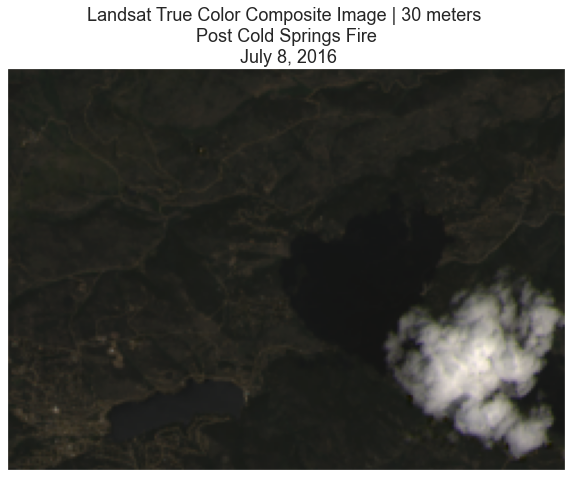

In [9]:
landsat_paths_pre_path = os.path.join(
    "cold-springs-fire",
    "landsat_collect",
    "LC080340322016070701T1-SC20180214145604",
    "crop",
    "*band[2-5]*.tif")

landsat_pre = combine_tifs(sorted(glob(landsat_paths_pre_path)))

# Notice there is a large cloud covering  part of the scene
ep.plot_rgb(landsat_pre.values,
            rgb=[2, 1, 0],
            title=("Landsat True Color Composite Image | "
                   "30 meters \n Post Cold Springs Fire \n July 8, 2016"))

plt.show()

Notice in the data above there is a large cloud in your scene. This cloud will impact any quantitative analysis that you perform on the data. You can remove cloudy pixels using a mask. Masking "bad" pixels:

1. Allows you to remove them from any quantitative analysis that you may perform such as calculating NDVI. 
2. Allows you to replace them (if you want) with better pixels from another scene. This replacement if often performed when performing time series analysis of data. The following lesson will teach you have to replace pixels in a scene. 

## Cloud Masks in Python

You can use the cloud mask layer to identify pixels that are likely to be clouds
or shadows. You can then set those pixel values to `masked` so they are not included in
your quantitative analysis in Python.

When you say "mask", you are talking about a layer that "turns off" or sets to `nan`,
the values of pixels in a raster that you don't want to include in an analysis.
It's very similar to setting data points that equal -9999 to `nan` in a time series
data set. You are just doing it with spatial raster data instead.


![Raster masks](https://www.earthdatascience.org/images/earth-analytics/raster-data/raster_masks.jpg)


When you use a raster mask, you are defining what pixels you want to exclude from a quantitative analysis. Notice in this image, the raster max is simply a layer that contains values of 1 (use these pixels) and values of NA (exclude these pixels). If the raster is the same extent and spatial resolution as your remote sensing data (in this case your landsat raster stack) you can then mask ALL PIXELS that occur at the spatial location of clouds and shadows (represented by an NA in the image above). Source: Colin Williams (NEON)


## Raster Masks for Remote Sensing Data

Many remote sensing data sets come with quality layers that you can use as a mask 
to remove "bad" pixels from your analysis. In the case of Landsat, the mask layers
identify pixels that are likely representative of cloud cover, shadow and even water. 
When you download Landsat 8 data from Earth Explorer, the data came with a processed 
cloud shadow / mask raster layer called `landsat_file_name_pixel_qa.tif`.
Just replace the name of your Landsat scene with the text landsat_file_name above. 
For this class the layer is:

`LC80340322016189-SC20170128091153/crop/LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif`

You will explore using this pixel quality assurance (QA) layer, next. To begin, open
the `pixel_qa` layer using rioxarray and plot it with matplotlib.


In [10]:
# Open the landsat qa layer
landsat_pre_cl_path = os.path.join(
    "cold-springs-fire",
    "landsat_collect",
    "LC080340322016070701T1-SC20180214145604",
    "crop",
    "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

This is just a demo for you to see what the cloud  mask layer looks like.

YOU DON'T NEED THIS CODE FOR YOUR HOMEWORK. Just look at the output plot

11


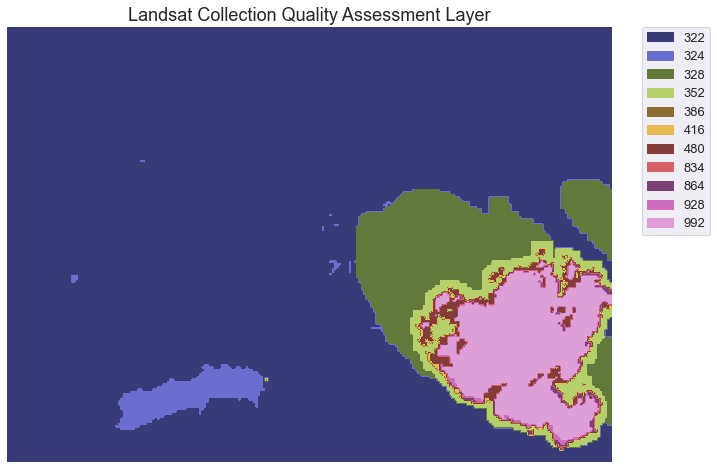

In [15]:
# This is optional code to plot the qa layer
# Don't worry too much about the details.
# Create a colormap with 11 colors
cmap = plt.cm.get_cmap('tab20b', 11)

# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa).tolist()
bins = [0] + vals

# Normalize the colormap
bounds = (
    [((a+b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1]-bins[-2]) + bins[-1]])
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, titles=vals)

ax.set_title("Landsat Collection Quality Assessment Layer")
ax.set_axis_off()
plt.show()

In the image above, you can see the cloud and the shadow that is obstructing our landsat image.
Unfortunately for you, this cloud covers a part of your analysis area in the Cold Springs
Fire location. There are a few ways to handle this issue. We will look at one:
simply masking out or removing the cloud for your analysis, first. 

To remove all pixels that are cloud and cloud shadow covered we need to first
determine what each value in our qa raster represents. The table below is from the USGS landsat website.
It describes what all of the values in the pixel_qa layer represent.

We are interested in 

1. cloud shadow
2. cloud and 
3. high confidence cloud

Note that your specific analysis may require a different set of masked pixels. For instance, your analysis may 
require you identify pixels that are low confidence clouds too. We are just using these classes
for the purpose of this class. 


| Attribute                | Pixel Value                                                     | 
|--------------------------|-----------------------------------------------------------------| 
| Fill                     | 1                                                               | 
| Clear                    | 322, 386, 834, 898, 1346                                        | 
| Water                    | 324, 388, 836, 900, 1348                                        | 
| Cloud Shadow             | 328, 392, 840, 904, 1350                                        | 
| Snow/Ice                 | 336, 368, 400, 432, 848, 880, 912, 944, 1352                    | 
| Cloud                    | 352, 368, 416, 432, 480, 864, 880, 928, 944, 992                | 
| Low confidence cloud     | 322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880      | 
| Medium confidence cloud  | 386, 388, 392, 400, 416, 432, 900, 904, 928, 944                | 
| High confidence cloud    | 480, 992                                                        | 
| Low confidence cirrus    | 322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480 | 
| High confidence cirrus   | 834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992 | 
| Terrain occlusion        | 1346, 1348, 1350, 1352                                          | 
==|

To better understand the values above, create a better map of the data. To do that you will:

1. classify the data into x classes where x represents the total number of unique values in the `pixel_qa` raster.
2. plot the data using these classes.

We are reclassifying the data because matplotlib colormaps will assign colors to values along a continuous gradient.
Reclassifying the data allows us to enforce one color for each unique value in our data. 


This next section shows you how to create a mask using the xarray function `isin()` to create a binary cloud mask layer. In this mask all pixels that you wish to remove from your analysis or mask will be set to `1`. All other pixels which represent pixels you want to use in your analysis will be set to `0`.

In [29]:
# You can grab the cloud pixel values from earthpy
high_cloud_confidence = (
    em.pixel_flags['pixel_qa']['L8']['High Cloud Confidence'])
cloud = em.pixel_flags['pixel_qa']['L8']['Cloud']
cloud_shadow = em.pixel_flags['pixel_qa']['L8']['Cloud Shadow']

all_masked_values = high_cloud_confidence + cloud + cloud_shadow
all_masked_values

[480,
 992,
 352,
 368,
 416,
 432,
 480,
 864,
 880,
 928,
 944,
 992,
 328,
 392,
 840,
 904,
 1350]

In [32]:
# This is using a the isin function to create a binary cloud mask
# You don't need to do this in your workflow
# As you can perform the mask in one step
# But we have it here for demonstration purposes
cl_mask = landsat_qa.isin(all_masked_values)
np.unique(cl_mask)

array([False,  True])

Below is the plot of the reclassified raster mask created from the `_create_mask` helper function.
You can think of this as creating a raster layer that is true / false

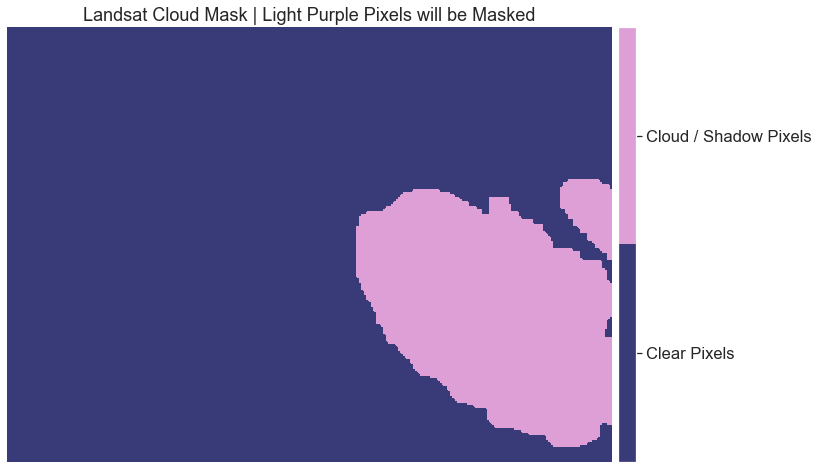

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(cl_mask,
               cmap=plt.cm.get_cmap('tab20b', 2))

cbar = ep.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])

ax.set_title("Landsat Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()

plt.show()

## What Does the Metadata Tell You?

You just explored two layers that potentially have information about cloud cover.
However what do the values stored in those rasters mean? You can refer to the
metadata provided by USGS to learn more about how
each layer in your landsat dataset are both stored and calculated.

When you download remote sensing data, often (but not always), you will find layers
that tell us more about the error and uncertainty in the data. Often whomever
created the data will do some of the work for us to detect where clouds and
shadows are - given they are common challenges that you need to work around when
using remote sensing data.


### Create Mask Layer in Python

To create the mask this you do the following:

1. Make sure you use a raster layer for the mask that is the SAME EXTENT and the same pixel resolution as your landsat scene. In this case you have a mask layer that is already the same spatial resolution and extent as your landsat scene.
2. Set all of the values in that layer that are clouds and / or shadows to `True`
3. Finally you use the `where` function to apply the mask layer to the xarray DataArray (or the landsat scene that you are working with in Python).  all pixel locations that were flagged as clouds or shadows in your mask to `NA` in your `raster` or in this case `rasterstack`.

## Mask A Landsat Scene Using Xarray
Below you mask your data in one single step. This function `.where()` applies the mask you created above to your xarray DataArray. To apply the mask, ensure you put a `~` in front of your mask inside the `where()` function. This must be done because `isin()` creates the mask with `True` values where we want `False`, values, and vice versa. The `~` flips all of the values inside the array.

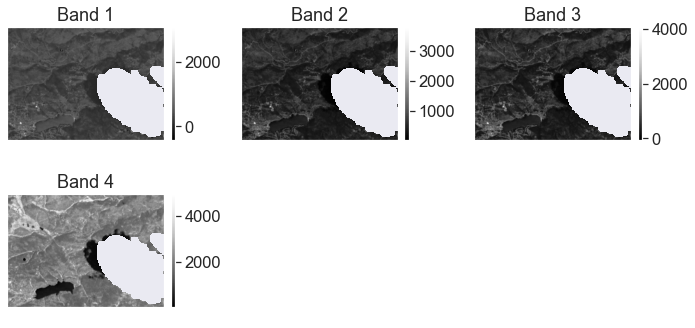

In [36]:
# Mask the data with the cloud mask
landsat_pre_cl_free = landsat_pre.where(~cl_mask)

# When you mask the data notice that the pixels with clouds are 
# Replaced with no data values
ep.plot_bands(landsat_pre_cl_free,
              figsize=(10,5))

plt.show()

In [48]:
# Mask the data using xarray.where 
# This essentially tells python to set any values where the two rasters 
# Overlay and are  within the cloud mask value range specified
# in all_masked_values above to NAN or not a number (masked data)
landsat_pre_cl_free_xr = landsat_pre.where(~landsat_qa.isin(all_masked_values))

type(landsat_pre_cl_free_xr)


xarray.core.dataarray.DataArray

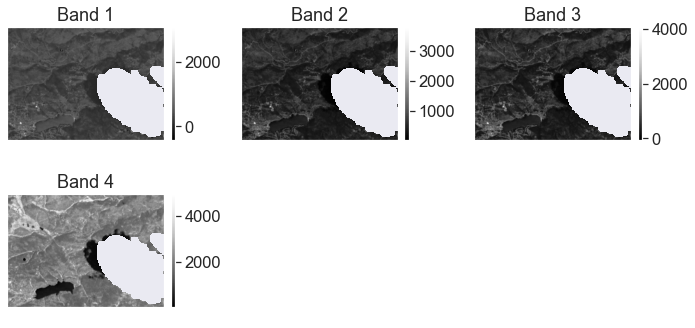

In [49]:
# When you mask the data notice that the pixels with clouds are 
# Replaced with no data values
ep.plot_bands(landsat_pre_cl_free_xr,
             figsize=(10,5))

plt.show()

Alternatively, you can directly input your mask values and the pixel QA layer into the `mask_pixels` function. This is the easiest way to mask your data! Again, this function only takes numpy arrays, so make sure to call `.values` on all of your xarray DataArrays that you are using as inputs into that function.

In [47]:
# Call the earthpy mask function using pixel QA layer
landsat_pre_cl_free_ma = em.mask_pixels(landsat_pre.values, 
                                        landsat_qa.values, 
                                        vals=all_masked_values)
type(landsat_pre_cl_free_ma)

numpy.ma.core.MaskedArray

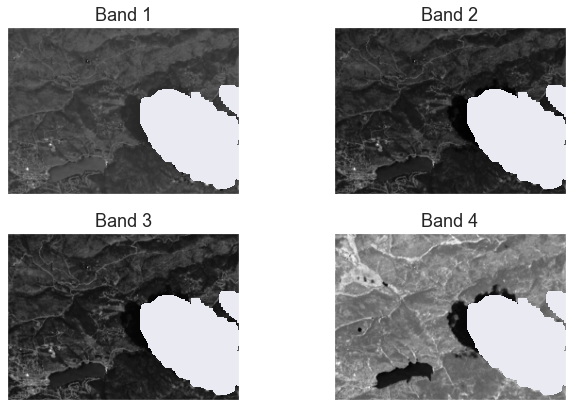

In [44]:
# Plot the data - notice that the data are not masked where the cloud covered pixels were
ep.plot_bands(landsat_pre_cl_free,
              cbar=False,
              figsize=(10,6),
              cols=2)
plt.show()

## The Code Below is Extra In Case You Want to Plot The  Data
You don't need this code for your homework!!

Below you can see how to cleanup the masked data for plotting.

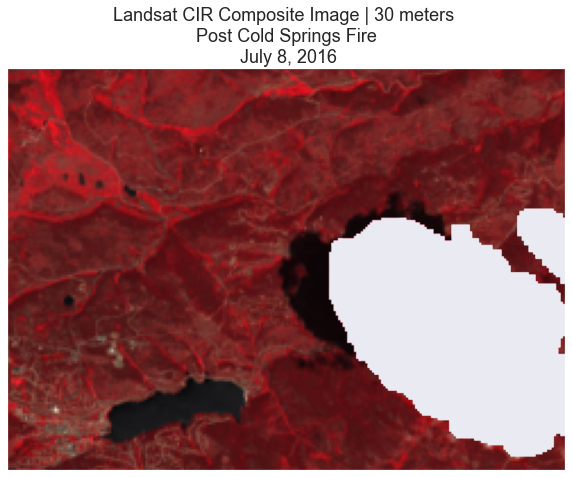

In [51]:
# Plot data
# Fix to plot xarray with plot_rgb
landsat_pre_cl_free_plot = ma.masked_array(landsat_pre_cl_free_xr, 
                                           landsat_pre_cl_free_xr.isnull())

# Plot
ep.plot_rgb(landsat_pre_cl_free_ma,
            rgb=[3, 2, 1],
            title=("Landsat CIR Composite Image | 30 meters \n"
                   " Post Cold Springs Fire \n"
                   " July 8, 2016"))
plt.show()